In [1]:

from __future__ import annotations


from pathlib import Path
import json, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

THESIS_COLORS = {
    "primary": "#1F4E79",   # line
    "accent":  "#D99C2B",   # optimal points
    "muted":   "#E6E6E6",   # grid / no-solution points
    "bad":     "#B34E4E",   # non-optimal points
    "text":    "#1A1A1A",
}

RESULTS_DIR = Path("/home/natalia/Repos/Thesis/BPCVRP/Scripts/results")
SEED_RE = re.compile(r"seed(\d+)", re.IGNORECASE)

In [2]:
rows = []

for p in RESULTS_DIR.rglob("*.json"):
    with open(p, "r", encoding="utf-8") as f:
        d = json.load(f)

    instance_path = d.get("instance_path", "")
    m = SEED_RE.search(instance_path)
    seed = int(m.group(1)) if m else None

    d["seed"] = seed
    d["n"] = int(seed / 1000)
    d["model"] = p.parent.name
    d["json_path"] = str(p)

    rows.append(d)

df = pd.DataFrame(rows)

In [3]:
df.head()

,instance_path,status,has_solution,objective,time,solution,raw_result,seed,n,model,json_path
0,/home/natalia/Repos/Thesis/BPCVRP/Scripts/data...,OPTIMAL_SOLUTION,True,385.0,1.116135,"{'successor': [17, 3, 16, 14, 13, 4, 5, 6, 15,...","objective = 385;\nvehicle = [5, 4, 4, 2, 1, 2,...",6042,6,vrp,/home/natalia/Repos/Thesis/BPCVRP/Scripts/resu...
1,/home/natalia/Repos/Thesis/BPCVRP/Scripts/data...,OPTIMAL_SOLUTION,True,160.0,0.109319,"{'successor': [7, 8, 9, 1, 2, 3, 5, 6, 4], 'pr...","objective = 160;\nvehicle = [1, 2, 3, 1, 2, 3,...",3046,3,vrp,/home/natalia/Repos/Thesis/BPCVRP/Scripts/resu...
2,/home/natalia/Repos/Thesis/BPCVRP/Scripts/data...,OPTIMAL_SOLUTION,True,414.0,1660.263881,"{'successor': [9, 7, 5, 20, 26, 25, 8, 21, 6, ...","objective = 414;\nvehicle = [7, 3, 8, 2, 8, 7,...",9044,9,vrp,/home/natalia/Repos/Thesis/BPCVRP/Scripts/resu...
3,/home/natalia/Repos/Thesis/BPCVRP/Scripts/data...,OPTIMAL_SOLUTION,True,295.0,0.122398,"{'successor': [2, 8, 9, 7, 1, 3, 5, 6, 4], 'pr...","objective = 295;\nvehicle = [2, 2, 3, 1, 2, 3,...",3045,3,vrp,/home/natalia/Repos/Thesis/BPCVRP/Scripts/resu...
4,/home/natalia/Repos/Thesis/BPCVRP/Scripts/data...,OPTIMAL_SOLUTION,True,396.0,268.875336,"{'successor': [4, 22, 8, 24, 6, 23, 1, 21, 18,...","objective = 396;\nvehicle = [8, 6, 5, 8, 7, 7,...",8043,8,vrp,/home/natalia/Repos/Thesis/BPCVRP/Scripts/resu...


In [4]:
cols = ["model", "status", "has_solution", "objective", "time", "seed", "n"]
df = df.loc[:, cols]
df.head()

,model,status,has_solution,objective,time,seed,n
0,vrp,OPTIMAL_SOLUTION,True,385.0,1.116135,6042,6
1,vrp,OPTIMAL_SOLUTION,True,160.0,0.109319,3046,3
2,vrp,OPTIMAL_SOLUTION,True,414.0,1660.263881,9044,9
3,vrp,OPTIMAL_SOLUTION,True,295.0,0.122398,3045,3
4,vrp,OPTIMAL_SOLUTION,True,396.0,268.875336,8043,8


In [8]:
OUT_DIR = Path("figures/q1_runtime")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# aggregate: mean over seeds for each (model, n)
g = (
    df.groupby(["model", "n"], as_index=False)
      .agg(
          time_mean=("time", "mean"),
          all_optimal=("status", lambda s: (s == "OPTIMAL_SOLUTION").all())
      )
      .sort_values(["model", "n"])
)

def save_runtime_plot_one_model(model_name: str, sub):
    xs = sub["n"].astype(int).to_numpy()
    ys = sub["time_mean"].astype(float).to_numpy()
    oks = sub["all_optimal"].astype(bool).to_numpy()

    fig, ax = plt.subplots(figsize=(7.5, 4.5))

    # line + markers (same as your utils style)
    ax.plot(xs, ys, color=THESIS_COLORS["primary"], linewidth=2, marker="o", markersize=5, label="Time")

    # overlay optimal / not optimal points
    ax.scatter(xs[oks], ys[oks],
               color=THESIS_COLORS["accent"],
               edgecolor=THESIS_COLORS["text"],
               s=60, label="Optimal", zorder=3)

    ax.scatter(xs[~oks], ys[~oks],
               color=THESIS_COLORS["bad"],
               marker="X",
               s=70, label="Not optimal", zorder=3)

    ax.set_title(f"{model_name} runtime vs n (mean over seeds)")
    ax.set_xlabel("n")
    ax.set_ylabel("Time [s]")
    ax.grid(axis="y", color=THESIS_COLORS["muted"], linestyle="--", linewidth=0.8)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(frameon=False)

    # if runtime grows fast, log helps (comment out if you want linear)
    # ax.set_yscale("log")

    fig.tight_layout()
    out_path = OUT_DIR / f"{model_name}_runtime_vs_n.png"
    fig.savefig(out_path, dpi=200)
    plt.close(fig)
    print("Saved:", out_path)

# make one image per model
for model_name in sorted(g["model"].unique()):
    sub = g[g["model"] == model_name].sort_values("n")
    save_runtime_plot_one_model(model_name, sub)


Saved: figures/q1_runtime/bpcsdvrp_runtime_vs_n.png
Saved: figures/q1_runtime/bpcsdvrp_grouped_runtime_vs_n.png
Saved: figures/q1_runtime/bpcvrp_runtime_vs_n.png
Saved: figures/q1_runtime/bpp_runtime_vs_n.png
Saved: figures/q1_runtime/sdvrp_runtime_vs_n.png
Saved: figures/q1_runtime/sdvrp_vs_cvrp_runtime_vs_n.png
Saved: figures/q1_runtime/vrp_runtime_vs_n.png


Paired instances: 15


,n,seed,obj_vrp,opt_vrp,time_vrp,obj_sd,opt_sd,time_sd,impr_abs,impr_pct
0,2,2042,144.0,True,0.152678,144.0,True,0.174250,0.0,0.0
1,2,2043,90.0,True,0.110623,90.0,True,0.158850,0.0,0.0
2,2,2044,127.0,True,0.113778,127.0,True,0.154192,0.0,0.0
3,2,2045,105.0,True,0.108325,105.0,True,0.159915,0.0,0.0
4,2,2046,87.0,True,0.116689,87.0,True,0.152195,0.0,0.0


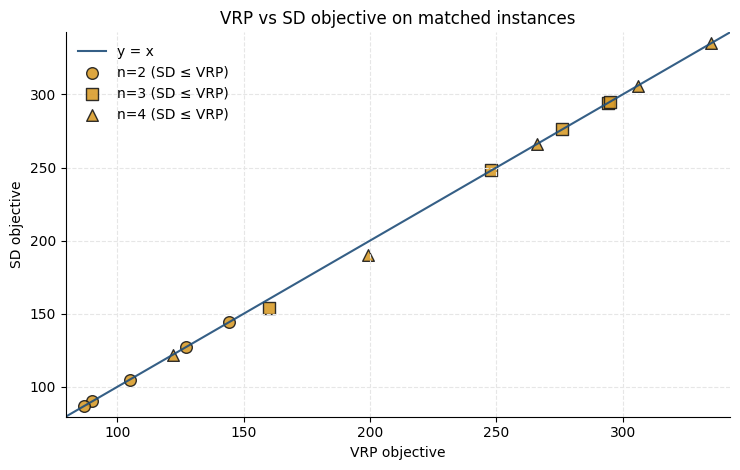

Saved: figures/q2_quality/vrp_vs_sdvrp_scatter_matched.png


In [36]:
OUT_DIR = Path("figures/q2_quality")
OUT_DIR.mkdir(parents=True, exist_ok=True)

def best_per_instance(df_sub):
    """One row per (n, seed): best feasible objective (min), keeps a simple status label."""
    d = df_sub[df_sub["has_solution"] == True].copy()
    d["objective"] = pd.to_numeric(d["objective"], errors="coerce")
    d = d.dropna(subset=["objective"])
    return (d.groupby(["n", "seed"], as_index=False)
              .agg(
                  obj=("objective", "min"),
                  optimal=("status", lambda s: (s == "OPTIMAL_SOLUTION").any()),
                  time=("time", "min"),
              ))

# --- get paired data on identical instances (same n, same seed) ---
vrp = best_per_instance(df[df["model"] == "vrp"]).rename(columns={"obj": "obj_vrp", "optimal": "opt_vrp", "time": "time_vrp"})
sd  = best_per_instance(df[df["model"] == "sdvrp_vs_cvrp"]).rename(columns={"obj": "obj_sd",  "optimal": "opt_sd",  "time": "time_sd"})

paired = pd.merge(vrp, sd, on=["n", "seed"], how="inner")

# improvements (positive means SD is better i.e. smaller objective)
paired["impr_abs"] = paired["obj_vrp"] - paired["obj_sd"]
paired["impr_pct"] = 100.0 * paired["impr_abs"] / paired["obj_vrp"]

print("Paired instances:", len(paired))
display(paired.head())

# --- PLOT: scatter with y=x diagonal ---
markers = {2: "o", 3: "s", 4: "^"}   # adjust if you have other n

fig, ax = plt.subplots(figsize=(7.5, 4.8))

# diagonal bounds
all_vals = np.r_[paired["obj_vrp"].to_numpy(), paired["obj_sd"].to_numpy()]
lo, hi = float(np.min(all_vals)), float(np.max(all_vals))
pad = 0.03 * (hi - lo) if hi > lo else 1.0
lo, hi = lo - pad, hi + pad

ax.plot([lo, hi], [lo, hi], color=THESIS_COLORS["primary"], linewidth=1.5, alpha=0.9, label="y = x")

# plot per n (same color scheme, different markers)
for n, sub in paired.groupby("n"):
    n_int = int(n)
    mk = markers.get(n_int, "o")

    good = sub[sub["impr_abs"] >= 0]   # SD <= VRP (expected)
    bad  = sub[sub["impr_abs"] < 0]    # SD > VRP (can happen if one side not optimal)

    if len(good):
        ax.scatter(good["obj_vrp"], good["obj_sd"],
                   marker=mk, s=70,
                   facecolor=THESIS_COLORS["accent"],
                   edgecolor=THESIS_COLORS["text"],
                   alpha=0.9,
                   label=f"n={n_int} (SD ≤ VRP)")
    if len(bad):
        ax.scatter(bad["obj_vrp"], bad["obj_sd"],
                   marker="X", s=80,
                   color=THESIS_COLORS["bad"],
                   alpha=0.9,
                   label=f"n={n_int} (SD > VRP)")

ax.set_title("VRP vs SD objective on matched instances")
ax.set_xlabel("VRP objective")
ax.set_ylabel("SD objective")
ax.grid(True, color=THESIS_COLORS["muted"], linestyle="--", linewidth=0.8)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlim(lo, hi)
ax.set_ylim(lo, hi)

# de-duplicate legend entries
handles, labels = ax.get_legend_handles_labels()
seen = set()
h2, l2 = [], []
for h, l in zip(handles, labels):
    if l not in seen:
        h2.append(h); l2.append(l); seen.add(l)
ax.legend(h2, l2, frameon=False, loc="upper left")

fig.tight_layout()
out_path = OUT_DIR / "vrp_vs_sdvrp_scatter_matched.png"
fig.savefig(out_path, dpi=200)
plt.show()

print("Saved:", out_path)

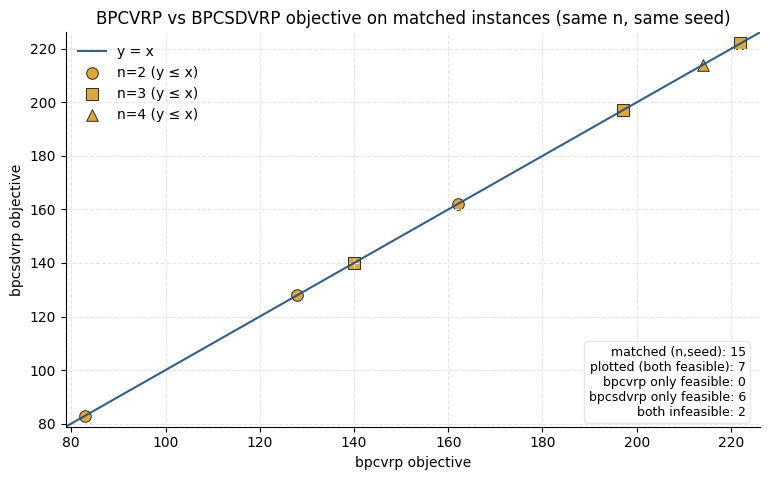

Saved: figures/q2_quality/bpcvrp_vs_bpcsdvrp_scatter_matched.png
matched (n,seed): 15
plotted (both feasible): 7
bpcvrp only feasible: 0
bpcsdvrp only feasible: 6
both infeasible: 2


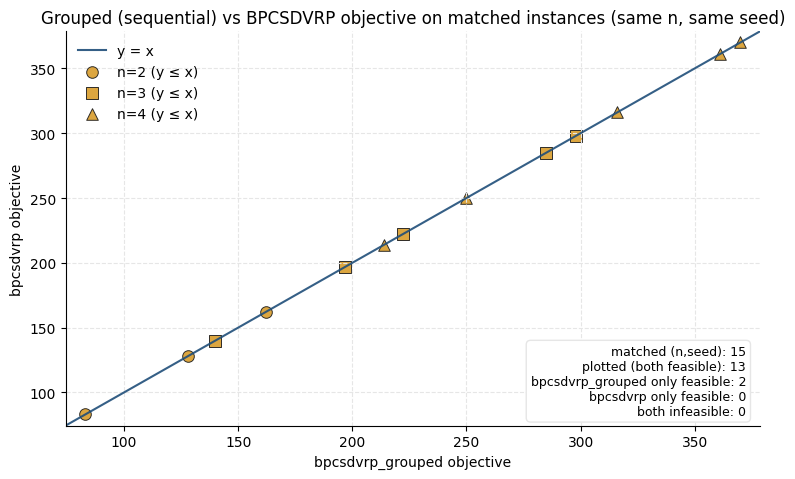

Saved: figures/q2_quality/bpcsdvrp_grouped_vs_bpcsdvrp_scatter_matched.png
matched (n,seed): 15
plotted (both feasible): 13
bpcsdvrp_grouped only feasible: 2
bpcsdvrp only feasible: 0
both infeasible: 0


In [12]:
OUT_DIR = Path("figures/q2_quality")
OUT_DIR.mkdir(parents=True, exist_ok=True)

def instance_summary(df_model: pd.DataFrame) -> pd.DataFrame:
    """
    One row per (n, seed) telling whether ANY run was feasible and what statuses appeared.
    """
    g = df_model.groupby(["n", "seed"], as_index=False).agg(
        feasible=("has_solution", "any"),
        any_opt=("status", lambda s: (s == "OPTIMAL_SOLUTION").any()),
        any_sat=("status", lambda s: (s == "SATISFIED").any()),
        any_unsat=("status", lambda s: (s == "UNSATISFIABLE").any()),
    )
    return g

def best_objective(df_model: pd.DataFrame) -> pd.DataFrame:
    """
    One row per (n, seed) with best (min) objective among feasible runs.
    """
    d = df_model.copy()
    d["objective"] = pd.to_numeric(d["objective"], errors="coerce")
    d = d[(d["has_solution"] == True) & d["objective"].notna()]
    best = d.groupby(["n", "seed"], as_index=False).agg(
        obj=("objective", "min"),
        optimal=("status", lambda s: (s == "OPTIMAL_SOLUTION").any()),
    )
    return best

def paired_scatter(df_all: pd.DataFrame, model_x: str, model_y: str, title: str, out_name: str):
    """
    Scatter plot: x-axis = objective(model_x), y-axis = objective(model_y), matched by (n, seed).
    Diagonal y=x; points below diagonal mean model_y is better (smaller objective).
    Also reports/annotates infeasible pairs (e.g., UNSAT in bpcvrp).
    """
    dx = df_all[df_all["model"] == model_x].copy()
    dy = df_all[df_all["model"] == model_y].copy()

    # per-instance feasibility summaries (so we can count UNSAT/feasible mismatches)
    sx = instance_summary(dx).rename(columns={"feasible": "feas_x"})
    sy = instance_summary(dy).rename(columns={"feasible": "feas_y"})
    keys = pd.merge(sx[["n","seed","feas_x"]], sy[["n","seed","feas_y"]], on=["n","seed"], how="inner")

    both_feas = keys[(keys["feas_x"] == True) & (keys["feas_y"] == True)]
    x_only    = keys[(keys["feas_x"] == True) & (keys["feas_y"] == False)]
    y_only    = keys[(keys["feas_x"] == False) & (keys["feas_y"] == True)]
    both_infe = keys[(keys["feas_x"] == False) & (keys["feas_y"] == False)]

    # objectives for feasible instances
    bx = best_objective(dx).rename(columns={"obj": "obj_x", "optimal": "opt_x"})
    by = best_objective(dy).rename(columns={"obj": "obj_y", "optimal": "opt_y"})
    paired = pd.merge(bx, by, on=["n","seed"], how="inner")

    # --------- make the figure ----------
    fig, ax = plt.subplots(figsize=(7.8, 4.9))

    # diagonal bounds
    vals = np.r_[paired["obj_x"].to_numpy(), paired["obj_y"].to_numpy()]
    lo, hi = float(np.min(vals)), float(np.max(vals))
    pad = 0.03 * (hi - lo) if hi > lo else 1.0
    lo, hi = lo - pad, hi + pad
    ax.plot([lo, hi], [lo, hi], color=THESIS_COLORS["primary"], linewidth=1.5, alpha=0.9, label="y = x")

    # marker by n
    marker_cycle = ["o","s","^","D","v","P","X","*"]
    ns = sorted(paired["n"].unique())
    marker_map = {int(n): marker_cycle[i % len(marker_cycle)] for i, n in enumerate(ns)}

    # color: SD/integrated better = below diagonal => obj_y <= obj_x
    for n, sub in paired.groupby("n"):
        mk = marker_map.get(int(n), "o")
        y_better = sub[sub["obj_y"] <= sub["obj_x"]]
        y_worse  = sub[sub["obj_y"] >  sub["obj_x"]]

        if len(y_better):
            ax.scatter(y_better["obj_x"], y_better["obj_y"],
                       marker=mk, s=70,
                       facecolor=THESIS_COLORS["accent"],
                       edgecolor=THESIS_COLORS["text"],
                       linewidth=0.7, alpha=0.9,
                       label=f"n={int(n)} (y ≤ x)")
        if len(y_worse):
            ax.scatter(y_worse["obj_x"], y_worse["obj_y"],
                       marker="X", s=80,
                       color=THESIS_COLORS["bad"], alpha=0.9,
                       label=f"n={int(n)} (y > x)")

    ax.set_title(title)
    ax.set_xlabel(f"{model_x} objective")
    ax.set_ylabel(f"{model_y} objective")
    ax.grid(True, color=THESIS_COLORS["muted"], linestyle="--", linewidth=0.8)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)

    # de-duplicate legend
    handles, labels = ax.get_legend_handles_labels()
    seen = set()
    h2, l2 = [], []
    for h, l in zip(handles, labels):
        if l not in seen:
            h2.append(h); l2.append(l); seen.add(l)
    ax.legend(h2, l2, frameon=False, loc="upper left")

    # annotate feasibility counts (important for bpcvrp UNSAT)
    note = (
        f"matched (n,seed): {len(keys)}\n"
        f"plotted (both feasible): {len(paired)}\n"
        f"{model_x} only feasible: {len(x_only)}\n"
        f"{model_y} only feasible: {len(y_only)}\n"
        f"both infeasible: {len(both_infe)}"
    )
    ax.text(0.98, 0.02, note, transform=ax.transAxes,
            ha="right", va="bottom", fontsize=9,
            bbox=dict(boxstyle="round,pad=0.35", facecolor="white", edgecolor=THESIS_COLORS["muted"]))

    fig.tight_layout()
    out_path = OUT_DIR / out_name
    fig.savefig(out_path, dpi=200)
    plt.show()

    print("Saved:", out_path)
    print(note)

# --- 1) BP-CVRP vs BP-SD-CVRP (expect many BP-CVRP UNSAT) ---
paired_scatter(
    df,
    model_x="bpcvrp",
    model_y="bpcsdvrp",
    title="BPCVRP vs BPCSDVRP objective on matched instances (same n, same seed)",
    out_name="bpcvrp_vs_bpcsdvrp_scatter_matched.png",
)

# --- 2) Sequential grouped vs integrated BP-SD-CVRP ---
paired_scatter(
    df,
    model_x="bpcsdvrp_grouped",
    model_y="bpcsdvrp",
    title="Grouped (sequential) vs BPCSDVRP objective on matched instances (same n, same seed)",
    out_name="bpcsdvrp_grouped_vs_bpcsdvrp_scatter_matched.png",
)


In [13]:
import pandas as pd
import numpy as np

def q1_runtime_table(df):
    d = df.copy()
    # ensure numeric
    d["time"] = pd.to_numeric(d["time"], errors="coerce")

    t1 = (d.groupby(["model","n"], as_index=False)
            .agg(
                k_runs=("seed","size"),
                mean_time_s=("time","mean"),
                opt_rate=("status", lambda s: (s == "OPTIMAL_SOLUTION").mean()),
                sat_rate=("status", lambda s: (s == "SATISFIED").mean()),
                unsat_rate=("status", lambda s: (s == "UNSATISFIABLE").mean()),
            ))

    t1["feasible_rate"] = 1.0 - t1["unsat_rate"]

    # format percentages nicely (still numeric, but rounded)
    t1["mean_time_s"] = t1["mean_time_s"].round(3)
    for c in ["opt_rate","sat_rate","unsat_rate","feasible_rate"]:
        t1[c] = (100 * t1[c]).round(1)

    # rename for thesis readability
    t1 = t1.rename(columns={
        "opt_rate": "%OPT",
        "sat_rate": "%SAT",
        "unsat_rate": "%UNSAT",
        "feasible_rate": "%feasible",
    }).sort_values(["model","n"])

    return t1

q1_table = q1_runtime_table(df)
q1_table

,model,n,k_runs,mean_time_s,%OPT,%SAT,%UNSAT,%feasible
0,bpcsdvrp,2,5,0.160,60.0,0.0,40.0,60.0
1,bpcsdvrp,3,5,1.359,100.0,0.0,0.0,100.0
2,bpcsdvrp,4,5,318.417,100.0,0.0,0.0,100.0
3,bpcsdvrp_grouped,2,5,0.709,100.0,0.0,0.0,100.0
4,bpcsdvrp_grouped,3,5,0.813,100.0,0.0,0.0,100.0
5,bpcsdvrp_grouped,4,5,1.004,100.0,0.0,0.0,100.0
6,bpcsdvrp_grouped,5,5,1.199,100.0,0.0,0.0,100.0
7,bpcsdvrp_grouped,6,5,1.607,100.0,0.0,0.0,100.0
8,bpcsdvrp_grouped,7,5,7.366,100.0,0.0,0.0,100.0
9,bpcsdvrp_grouped,8,5,33.485,100.0,0.0,0.0,100.0


In [14]:
q1_table_compact = (q1_table.groupby("model", as_index=False)
                    .agg(k_runs=("k_runs","sum"),
                         mean_time_s=("mean_time_s","mean"),
                         **{"%OPT":("%OPT","mean"), "%SAT":("%SAT","mean"),
                            "%UNSAT":("%UNSAT","mean"), "%feasible":("%feasible","mean")})
                    )
q1_table_compact = q1_table_compact.round({"mean_time_s":3, "%OPT":1, "%SAT":1, "%UNSAT":1, "%feasible":1})
q1_table_compact

,model,k_runs,mean_time_s,%OPT,%SAT,%UNSAT,%feasible
0,bpcsdvrp,15,106.645,86.7,0.0,13.3,86.7
1,bpcsdvrp_grouped,35,6.598,100.0,0.0,0.0,100.0
2,bpcvrp,35,0.173,31.4,0.0,68.6,31.4
3,bpp,50,1.318,100.0,0.0,0.0,100.0
4,sdvrp,15,4.296,100.0,0.0,0.0,100.0
5,sdvrp_vs_cvrp,15,11.519,100.0,0.0,0.0,100.0
6,vrp,39,443.093,96.9,3.1,0.0,100.0


In [15]:
def best_obj(df_sub):
    d = df_sub[df_sub["has_solution"] == True].copy()
    d["objective"] = pd.to_numeric(d["objective"], errors="coerce")
    d = d.dropna(subset=["objective"])
    return d.groupby(["n","seed"], as_index=False).agg(obj=("objective","min"))

def paired_improvement_table(df, model_A, model_B):
    # A is baseline, B is improved model; positive => B better (lower)
    A = best_obj(df[df["model"] == model_A]).rename(columns={"obj": "obj_A"})
    B = best_obj(df[df["model"] == model_B]).rename(columns={"obj": "obj_B"})

    paired = pd.merge(A, B, on=["n","seed"], how="inner")
    paired["impr_pct"] = 100.0 * (paired["obj_A"] - paired["obj_B"]) / paired["obj_A"]

    # summary by n + overall
    by_n = (paired.groupby("n", as_index=False)
            .agg(k_pairs=("impr_pct","size"),
                 mean_impr_pct=("impr_pct","mean"),
                 median_impr_pct=("impr_pct","median")))

    overall = pd.DataFrame([{
        "n": "ALL",
        "k_pairs": int(paired.shape[0]),
        "mean_impr_pct": float(paired["impr_pct"].mean()) if len(paired) else np.nan,
        "median_impr_pct": float(paired["impr_pct"].median()) if len(paired) else np.nan,
    }])

    out = pd.concat([by_n, overall], ignore_index=True)
    out["mean_impr_pct"] = out["mean_impr_pct"].round(3)
    out["median_impr_pct"] = out["median_impr_pct"].round(3)
    out = out.rename(columns={
        "mean_impr_pct": "mean_impr_%",
        "median_impr_pct": "median_impr_%",
    })
    return out, paired

q2_vrp_sd_table, paired_vrp_sd = paired_improvement_table(df, "vrp", "sdvrp_vs_cvrp")
q2_vrp_sd_table


,n,k_pairs,mean_impr_%,median_impr_%
0,2,5,0.000,0.0
1,3,5,0.750,0.0
2,4,5,0.905,0.0
3,ALL,15,0.552,0.0


In [16]:
q2_grouped_table, paired_grouped = paired_improvement_table(df, "bpcsdvrp_grouped", "bpcsdvrp")
q2_grouped_table

,n,k_pairs,mean_impr_%,median_impr_%
0,2,3,0.0,0.0
1,3,5,0.0,0.0
2,4,5,0.0,0.0
3,ALL,13,0.0,0.0


In [17]:
import pandas as pd

vrp_models = ["vrp", "sdvrp", "sdvrp_vs_cvrp"]  # adjust if needed

t_vrp_time = (
    df[df["model"].isin(vrp_models)]
    .assign(time=pd.to_numeric(df["time"], errors="coerce"))
    .groupby(["n", "model"], as_index=False)
    .agg(
        k_runs=("seed", "size"),
        mean_time_s=("time", "mean"),
    )
    .sort_values(["n", "model"])
)

# wide format: one row per n, one column per model (mean time)
t_vrp_time_wide = (
    t_vrp_time
    .pivot(index="n", columns="model", values="mean_time_s")
    .round(3)
    .reset_index()
)

# (optional) also keep sample sizes in a second wide table
t_vrp_k_wide = (
    t_vrp_time
    .pivot(index="n", columns="model", values="k_runs")
    .reset_index()
)

t_vrp_time_wide


model,n,sdvrp,sdvrp_vs_cvrp,vrp
0,2,0.161,0.160,0.120
1,3,0.291,0.712,0.117
2,4,12.437,33.686,0.126
3,5,NaN,NaN,0.194
4,6,NaN,NaN,0.888
5,7,NaN,NaN,7.960
6,8,NaN,NaN,123.175
7,9,NaN,NaN,3412.162


In [18]:
# merge mean and k, then format as "mean (k)"
tmp = t_vrp_time.copy()
tmp["cell"] = tmp["mean_time_s"].round(3).astype(str) + " (" + tmp["k_runs"].astype(int).astype(str) + ")"

t_vrp_time_mean_k = (
    tmp.pivot(index="n", columns="model", values="cell")
       .reset_index()
)

t_vrp_time_mean_k


model,n,sdvrp,sdvrp_vs_cvrp,vrp
0,2,0.161 (5),0.16 (5),0.12 (5)
1,3,0.291 (5),0.712 (5),0.117 (5)
2,4,12.437 (5),33.686 (5),0.126 (5)
3,5,NaN,NaN,0.194 (5)
4,6,NaN,NaN,0.888 (5)
5,7,NaN,NaN,7.96 (5)
6,8,NaN,NaN,123.175 (5)
7,9,NaN,NaN,3412.162 (4)


In [19]:
import pandas as pd

bpc_models = ["bpcvrp", "bpcsdvrp", "bpcsdvrp_grouped"]  # adjust names if needed

# long table: mean time per (n, model)
t_bpc_time = (
    df[df["model"].isin(bpc_models)]
    .assign(time=pd.to_numeric(df["time"], errors="coerce"))
    .groupby(["n", "model"], as_index=False)
    .agg(
        k_runs=("seed", "size"),
        mean_time_s=("time", "mean"),
    )
    .sort_values(["n", "model"])
)

# wide table: numeric mean time
t_bpc_time_wide = (
    t_bpc_time
    .pivot(index="n", columns="model", values="mean_time_s")
    .round(3)
    .reset_index()
)

# wide table: "mean (k)" strings
tmp = t_bpc_time.copy()
tmp["cell"] = tmp["mean_time_s"].round(3).astype(str) + " (" + tmp["k_runs"].astype(int).astype(str) + ")"

t_bpc_time_mean_k = (
    tmp.pivot(index="n", columns="model", values="cell")
       .reset_index()
)

t_bpc_time_wide, t_bpc_time_mean_k


(model  n  bpcsdvrp  bpcsdvrp_grouped  bpcvrp
 0      2     0.160             0.709   0.135
 1      3     1.359             0.813   0.144
 2      4   318.417             1.004   0.153
 3      5       NaN             1.199   0.178
 4      6       NaN             1.607   0.210
 5      7       NaN             7.366   0.185
 6      8       NaN            33.485   0.208,
 model  n     bpcsdvrp bpcsdvrp_grouped     bpcvrp
 0      2     0.16 (5)        0.709 (5)  0.135 (5)
 1      3    1.359 (5)        0.813 (5)  0.144 (5)
 2      4  318.417 (5)        1.004 (5)  0.153 (5)
 3      5          NaN        1.199 (5)  0.178 (5)
 4      6          NaN        1.607 (5)   0.21 (5)
 5      7          NaN        7.366 (5)  0.185 (5)
 6      8          NaN       33.485 (5)  0.208 (5))

In [20]:
t_bpc_feas = (
    df[df["model"].isin(bpc_models)]
    .groupby(["n","model"], as_index=False)
    .agg(
        feasible_rate=("has_solution", "mean"),
        unsat_rate=("status", lambda s: (s == "UNSATISFIABLE").mean()),
    )
)

t_bpc_feas["%feasible"] = (100 * t_bpc_feas["feasible_rate"]).round(1)
t_bpc_feas["%UNSAT"] = (100 * t_bpc_feas["unsat_rate"]).round(1)

t_bpc_feas_wide = (
    t_bpc_feas.pivot(index="n", columns="model", values="%feasible")
              .reset_index()
)

t_bpc_feas_wide


model,n,bpcsdvrp,bpcsdvrp_grouped,bpcvrp
0,2,60.0,100.0,60.0
1,3,100.0,100.0,60.0
2,4,100.0,100.0,20.0
3,5,NaN,100.0,40.0
4,6,NaN,100.0,40.0
5,7,NaN,100.0,0.0
6,8,NaN,100.0,0.0


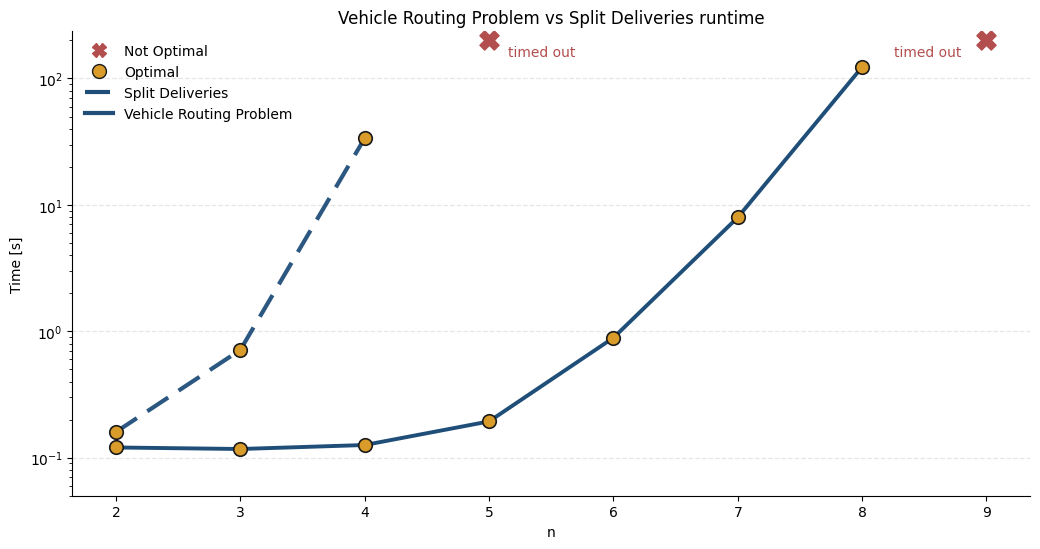

Saved: figures/q1_runtime/vrp_vs_sd_runtime_custom_legend_breaks_log.png


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path

THESIS_COLORS = {
    "primary": "#1F4E79",   # line
    "accent":  "#D99C2B",   # optimal points
    "muted":   "#E6E6E6",   # grid
    "bad":     "#B34E4E",   # not-optimal / timeout X
    "text":    "#1A1A1A",
}

OUT_DIR = Path("figures/q1_runtime")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Settings
USE_LOG_Y = True
Y_CLIP = 200
LOG_YMIN = 0.05
SD_SHOW_NS = [2, 3, 4]
SD_TIMEOUT_N = 5

# Breaks requested
BREAK_VRP_EDGE = (8, 9)   # no line from 8 to 9 for VRP
# SD already has no data at n=5; we plot X at 5, but no connecting line from 4 to 5.

def mean_time_by_n(df_model: pd.DataFrame) -> pd.DataFrame:
    return (df_model.groupby("n", as_index=False)
            .agg(time_mean=("time", "mean"),
                 all_optimal=("status", lambda s: (s == "OPTIMAL_SOLUTION").all()),
                 any_sat=("status", lambda s: (s == "SATISFIED").any()))
            .sort_values("n"))

def clip_y(y):
    return np.minimum(np.asarray(y, dtype=float), Y_CLIP)

# --- aggregate data ---
vrp_g = mean_time_by_n(df[df["model"] == "vrp"])
sd_g_all = mean_time_by_n(df[df["model"] == "sdvrp_vs_cvrp"])
sd_g = sd_g_all[sd_g_all["n"].isin(SD_SHOW_NS)].copy()

# --- figure ---
fig, ax = plt.subplots(figsize=(10.5, 5.6))

# =======================
# VRP line with break 8->9
# =======================
vrp_seg1 = vrp_g[vrp_g["n"] <= BREAK_VRP_EDGE[0]]
vrp_seg2 = vrp_g[vrp_g["n"] >= BREAK_VRP_EDGE[1]]

if len(vrp_seg1):
    ax.plot(vrp_seg1["n"], clip_y(vrp_seg1["time_mean"]),
            color=THESIS_COLORS["primary"], linewidth=2.8,
            marker="o", markersize=5, zorder=2)

if len(vrp_seg2):
    ax.plot(vrp_seg2["n"], clip_y(vrp_seg2["time_mean"]),
            color=THESIS_COLORS["primary"], linewidth=2.8,
            marker="o", markersize=5, zorder=2)

# VRP points: optimal O vs not-optimal X
xv = vrp_g["n"].astype(int).to_numpy()
yv = clip_y(vrp_g["time_mean"].to_numpy())
vrp_opt = vrp_g["all_optimal"].astype(bool).to_numpy()

ax.scatter(xv[vrp_opt], yv[vrp_opt], s=95,
           facecolor=THESIS_COLORS["accent"], edgecolor=THESIS_COLORS["text"],
           linewidth=1.2, zorder=4)

ax.scatter(xv[~vrp_opt], yv[~vrp_opt], s=150, marker="X",
           color=THESIS_COLORS["bad"], zorder=5)

# VRP timeout X at last point if SATISFIED or clipped
if len(vrp_g) > 0:
    last = vrp_g.iloc[-1]
    n_last = int(last["n"])
    y_last = float(last["time_mean"])
    if bool(last["any_sat"]) or (y_last > Y_CLIP):
        ax.scatter([n_last], [Y_CLIP], s=190, marker="X",
                   color=THESIS_COLORS["bad"], zorder=8)
        ax.annotate("timed out", xy=(n_last, Y_CLIP),
                    xytext=(n_last - 0.2, Y_CLIP * 0.92),
                    color=THESIS_COLORS["bad"], fontsize=10,
                    ha="right", va="top")

# =======================
# SD dashed line ONLY for n=2,3,4 (no line 4->5)
# =======================
xs = sd_g["n"].astype(int).to_numpy()
ys = clip_y(sd_g["time_mean"].to_numpy())

ax.plot(xs, ys,
        color=THESIS_COLORS["primary"], linewidth=3.0,
        linestyle="--", dashes=(6, 3),
        marker="o", markersize=5, alpha=0.95, zorder=2)

sd_opt = sd_g["all_optimal"].astype(bool).to_numpy()
ax.scatter(xs[sd_opt], ys[sd_opt], s=95,
           facecolor=THESIS_COLORS["accent"], edgecolor=THESIS_COLORS["text"],
           linewidth=1.2, zorder=4)

ax.scatter(xs[~sd_opt], ys[~sd_opt], s=150, marker="X",
           color=THESIS_COLORS["bad"], zorder=5)

# SD forced timeout X at n=5 (NO connecting line from 4->5)
ax.scatter([SD_TIMEOUT_N], [Y_CLIP], s=190, marker="X",
           color=THESIS_COLORS["bad"], zorder=8)
ax.annotate("timed out", xy=(SD_TIMEOUT_N, Y_CLIP),
            xytext=(SD_TIMEOUT_N + 0.15, Y_CLIP * 0.92),
            color=THESIS_COLORS["bad"], fontsize=10,
            ha="left", va="top")

# --- axes styling ---
ax.set_title("Vehicle Routing Problem vs Split Deliveries runtime")
ax.set_xlabel("n")
ax.set_ylabel("Time [s]")

xticks = sorted(set(vrp_g["n"].astype(int).tolist()) | set(SD_SHOW_NS) | {SD_TIMEOUT_N})
ax.set_xticks(xticks)

if USE_LOG_Y:
    ax.set_yscale("log")
    ax.set_ylim(LOG_YMIN, Y_CLIP * 1.18)  # headroom so X at 200 is fully visible
else:
    ax.set_ylim(0, Y_CLIP * 1.05)

ax.grid(axis="y", color=THESIS_COLORS["muted"], linestyle="--", linewidth=0.9)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# --- custom legend EXACTLY as requested ---
legend_handles = [
    Line2D([0], [0], marker="X", linestyle="None",
           markersize=10, markerfacecolor=THESIS_COLORS["bad"], markeredgecolor=THESIS_COLORS["bad"],
           label="Not Optimal"),
    Line2D([0], [0], marker="o", linestyle="None",
           markersize=10, markerfacecolor=THESIS_COLORS["accent"], markeredgecolor=THESIS_COLORS["text"],
           label="Optimal"),
    Line2D([0], [0], color=THESIS_COLORS["primary"], linestyle="--", dashes=(6, 3), linewidth=3,
           label="Split Deliveries"),
    Line2D([0], [0], color=THESIS_COLORS["primary"], linestyle="-", linewidth=3,
           label="Vehicle Routing Problem"),
]
ax.legend(handles=legend_handles, frameon=False, loc="upper left")

fig.tight_layout()
out_path = OUT_DIR / "vrp_vs_sd_runtime_custom_legend_breaks_log.png"
fig.savefig(out_path, dpi=200)
plt.show()

print("Saved:", out_path)


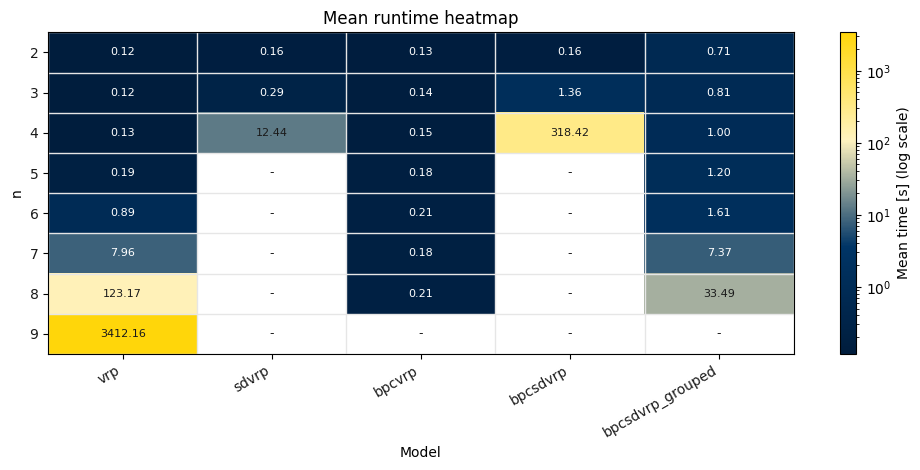

Saved: figures/q1_runtime/mean_time_heatmap_thesis_colors_adaptive_text.png


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap
from pathlib import Path

# thesis palette
THESIS_COLORS = {
    "primary": "#1F4E79",
    "accent":  "#D99C2B",
    "muted":   "#E6E6E6",
    "bad":     "#B34E4E",
    "text":    "#1A1A1A",
}

THESIS_DARK   = "#001D3D"
THESIS_MID    = "#003566"
THESIS_ACCENT = "#FFD60A"
THESIS_LIGHT  = "#FFF3BF"

OUT_DIR = Path("figures/q1_runtime")
OUT_DIR.mkdir(parents=True, exist_ok=True)

MODEL_ORDER = ["vrp", "sdvrp", "bpcvrp", "bpcsdvrp", "bpcsdvrp_grouped"]

# aggregate mean time per (n, model)
agg = (df[df["model"].isin(MODEL_ORDER)]
       .assign(time=pd.to_numeric(df["time"], errors="coerce"))
       .groupby(["n", "model"], as_index=False)
       .agg(mean_time=("time", "mean")))

mat = (agg.pivot(index="n", columns="model", values="mean_time")
          .reindex(columns=MODEL_ORDER)
          .sort_index())

data = mat.to_numpy()

# colormap: dark blue -> mid -> light -> yellow
cmap = LinearSegmentedColormap.from_list(
    "thesis_blue_yellow",
    [THESIS_DARK, THESIS_MID, THESIS_LIGHT, THESIS_ACCENT],
    N=256
)

# choose log scale (recommended for runtimes)
use_log = True
if use_log:
    finite_pos = data[np.isfinite(data) & (data > 0)]
    vmin = float(finite_pos.min()) if finite_pos.size else 1e-3
    vmax = float(finite_pos.max()) if finite_pos.size else 1.0
    norm = LogNorm(vmin=vmin, vmax=vmax)
else:
    norm = None

fig, ax = plt.subplots(figsize=(10, 4.8))

im = ax.imshow(
    data,
    aspect="auto",
    interpolation="nearest",
    cmap=cmap,
    norm=norm
)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Mean time [s] (log scale)" if use_log else "Mean time [s]")

# ticks / labels
ax.set_xticks(np.arange(len(mat.columns)))
ax.set_xticklabels(mat.columns, rotation=30, ha="right", color=THESIS_COLORS["text"])
ax.set_yticks(np.arange(len(mat.index)))
ax.set_yticklabels(mat.index.astype(int), color=THESIS_COLORS["text"])

ax.set_xlabel("Model")
ax.set_ylabel("n")
ax.set_title("Mean runtime heatmap")

# gridlines
ax.set_xticks(np.arange(-.5, len(mat.columns), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(mat.index), 1), minor=True)
ax.grid(which="minor", color=THESIS_COLORS["muted"], linestyle="-", linewidth=1)
ax.tick_params(which="minor", bottom=False, left=False)

# --- adaptive text color based on background luminance ---
def luminance(rgb):
    r, g, b = rgb[:3]
    # perceived luminance (simple + effective)
    return 0.2126*r + 0.7152*g + 0.0722*b

annotate = True
if annotate:
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            val = data[i, j]
            if not np.isfinite(val):
                ax.text(j, i, "-", ha="center", va="center", fontsize=9, color=THESIS_COLORS["text"])
                continue

            # compute cell background color (after norm + cmap)
            rgba = cmap(norm(val) if norm is not None else val)
            txt_color = "white" if luminance(rgba) < 0.45 else THESIS_COLORS["text"]

            ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8, color=txt_color)

fig.tight_layout()
out_path = OUT_DIR / "mean_time_heatmap_thesis_colors_adaptive_text.png"
fig.savefig(out_path, dpi=200)
plt.show()

print("Saved:", out_path)


In [51]:
import pandas as pd

# keep only feasible runs and numeric objectives
def best_obj(df_sub):
    d = df_sub[df_sub["has_solution"] == True].copy()
    d["objective"] = pd.to_numeric(d["objective"], errors="coerce")
    d = d.dropna(subset=["objective"])
    return d.groupby(["n", "seed"], as_index=False).agg(objective=("objective", "min"))

bpcsd = best_obj(df[df["model"] == "bpcsdvrp"]).rename(columns={"objective": "obj_bpcsdvrp"})
grp   = best_obj(df[df["model"] == "bpcsdvrp_grouped"]).rename(columns={"objective": "obj_grouped"})

# only instances where BOTH are feasible (inner join)
obj_df = pd.merge(bpcsd, grp, on=["n", "seed"], how="inner").sort_values(["n", "seed"])

obj_df


,n,seed,obj_bpcsdvrp,obj_grouped
0,2,2044,83.0,83.0
1,2,2045,162.0,162.0
2,2,2046,128.0,128.0
3,3,3042,298.0,298.0
4,3,3043,140.0,140.0
5,3,3044,197.0,197.0
6,3,3045,285.0,285.0
7,3,3046,222.0,222.0
8,4,4042,316.0,316.0
9,4,4043,370.0,370.0


In [52]:
import pandas as pd

# order + pretty names
MODEL_MAP = {
    "bpcvrp": "BPCVRP",
    "bpcsdvrp": "BP--SD--CVRP",
    "bpcsdvrp_grouped": "Sequential",
}
MODEL_ORDER = ["BPCVRP", "BP--SD--CVRP", "Sequential"]

# filter to BPC models + feasible only
d = df[df["model"].isin(MODEL_MAP.keys()) & (df["has_solution"] == True)].copy()
d["time"] = pd.to_numeric(d["time"], errors="coerce")
d = d.dropna(subset=["time"])
d["model_name"] = d["model"].map(MODEL_MAP)

# mean runtime over feasible runs, by n and model
runtime_feasible = (
    d.groupby(["n", "model_name"], as_index=False)
     .agg(k_feasible=("time", "size"),
          mean_time_s=("time", "mean"))
)

# wide table (rows=n, cols=model) in desired order
runtime_feasible_wide = (
    runtime_feasible.pivot(index="n", columns="model_name", values="mean_time_s")
    .reindex(columns=MODEL_ORDER)
    .sort_index()
    .round(3)
    .reset_index()
)

runtime_feasible_wide


model_name,n,BPCVRP,BP--SD--CVRP,Sequential
0,2,0.132,0.166,0.709
1,3,0.144,1.359,0.813
2,4,0.179,318.417,1.004
3,5,0.201,NaN,1.199
4,6,0.246,NaN,1.607
5,7,NaN,NaN,7.366
6,8,NaN,NaN,33.485


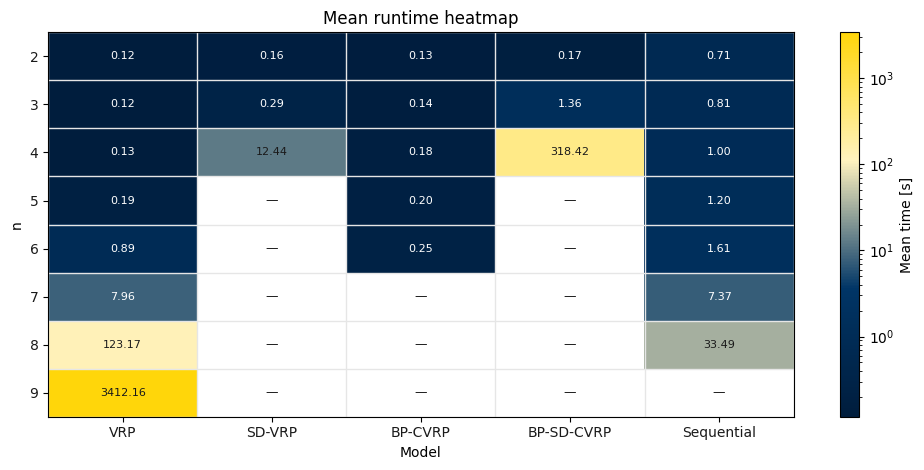

Saved: figures/q1_runtime/mean_time_heatmap.png


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap
from pathlib import Path

# thesis colors
THESIS_DARK   = "#001D3D"
THESIS_MID    = "#003566"
THESIS_ACCENT = "#FFD60A"
THESIS_LIGHT  = "#FFF3BF"
TEXT_COLOR    = "#1A1A1A"
GRID_MUTED    = "#E6E6E6"

OUT_DIR = Path("figures/q1_runtime")
OUT_DIR.mkdir(parents=True, exist_ok=True)

MODEL_ORDER = ["vrp", "sdvrp", "bpcvrp", "bpcsdvrp", "bpcsdvrp_grouped"]

# --- only feasible runs ---
d = df[df["model"].isin(MODEL_ORDER) & (df["has_solution"] == True)].copy()
d["time"] = pd.to_numeric(d["time"], errors="coerce")
d = d.dropna(subset=["time"])

# mean time per (n, model) over feasible runs only
agg = (d.groupby(["n", "model"], as_index=False)
         .agg(mean_time=("time", "mean")))

mat = (agg.pivot(index="n", columns="model", values="mean_time")
          .reindex(columns=MODEL_ORDER)
          .sort_index())

data = mat.to_numpy()

# thesis colormap: dark blue -> mid -> light -> yellow
cmap = LinearSegmentedColormap.from_list(
    "thesis_blue_yellow",
    [THESIS_DARK, THESIS_MID, THESIS_LIGHT, THESIS_ACCENT],
    N=256
)

# log scale for runtimes
use_log = True
if use_log:
    finite_pos = data[np.isfinite(data) & (data > 0)]
    vmin = float(finite_pos.min()) if finite_pos.size else 1e-3
    vmax = float(finite_pos.max()) if finite_pos.size else 1.0
    norm = LogNorm(vmin=vmin, vmax=vmax)
else:
    norm = None

fig, ax = plt.subplots(figsize=(10, 4.8))

im = ax.imshow(
    data,
    aspect="auto",
    interpolation="nearest",
    cmap=cmap,
    norm=norm
)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Mean time [s]" if use_log else "Mean time [s]")

# ticks / labels
ax.set_xticks(np.arange(len(mat.columns)))
ax.set_xticklabels(['VRP', 'SD-VRP', 'BP-CVRP', 'BP-SD-CVRP', 'Sequential'], color=TEXT_COLOR)
ax.set_yticks(np.arange(len(mat.index)))
ax.set_yticklabels(mat.index.astype(int), color=TEXT_COLOR)

ax.set_xlabel("Model")
ax.set_ylabel("n")
ax.set_title("Mean runtime heatmap")

# gridlines
ax.set_xticks(np.arange(-.5, len(mat.columns), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(mat.index), 1), minor=True)
ax.grid(which="minor", color=GRID_MUTED, linestyle="-", linewidth=1)
ax.tick_params(which="minor", bottom=False, left=False)

# adaptive text color (white on dark cells)
def luminance(rgb):
    r, g, b = rgb[:3]
    return 0.2126*r + 0.7152*g + 0.0722*b

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        val = data[i, j]
        if not np.isfinite(val):
            ax.text(j, i, "—", ha="center", va="center", fontsize=9, color=TEXT_COLOR)
            continue

        rgba = cmap(norm(val) if norm is not None else val)
        txt_color = "white" if luminance(rgba) < 0.45 else TEXT_COLOR
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8, color=txt_color)

fig.tight_layout()
out_path = OUT_DIR / "mean_time_heatmap.png"
fig.savefig(out_path, dpi=200)
plt.show()

print("Saved:", out_path)
